NOTE: This notebook is assuming you have the `daily_dataset.csv` inside the folder local_data in data, and the `pernoctacions_2019_2024.csv`, `temperature_precipitation.csv` and `tourism_flux.csv` datasets inside the folder data.

The `daily_dataset.csv` should be exactly how it is when it is being recently downloaded from the AB Datachallenge portal.

In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
pernoctacions = pd.read_csv('../data/pernoctacions_2019_2024.csv')
tourism = pd.read_csv('../data/tourism_flux.csv')
clima_df = pd.read_csv('../data/temperature_precipitation.csv')

In [3]:
# Load and prepare the data
import pandas as pd

# Load datasets
transactions = pd.read_csv('../data/targetes_preprocessed.csv')

# Convert date columns to datetime
pernoctacions['Data'] = pd.to_datetime(pernoctacions['Data'], format='%m/%d/%Y')
transactions['Data'] = pd.to_datetime(transactions['Data'], format='%Y-%m-%d')

# Clean and convert the 'Pernoctacions' column to numeric
pernoctacions['Pernoctacions'] = pd.to_numeric(pernoctacions['Pernoctacions'].str.replace('.', ''), errors='coerce')

# Group transactions by month and calculate the total transactions per month
monthly_transactions = transactions.groupby(transactions['Data'].dt.to_period('M'))['total_tourist_transactions'].sum().reset_index()
monthly_transactions.columns = ['Month', 'Total Transactions']

# Merge monthly totals with daily transactions to calculate daily percentages
transactions = transactions.merge(monthly_transactions, left_on=transactions['Data'].dt.to_period('M'), right_on='Month', how='left')
transactions['Percentage of Transactions'] = transactions['total_tourist_transactions'] / transactions['Total Transactions']

# Remove unnecessary column
transactions.drop(columns=['Month'], inplace=True)

# Initialize the results list
resultados = []

# Loop through each row in pernoctacions to distribute monthly totals across days
for _, row in pernoctacions.iterrows():
    mes = row['Data'].month
    anyo = row['Data'].year
    pernoctaciones_mensuales = row['Pernoctacions']
    
    # Filter the transactions for the current month and year
    transactions_mes = transactions[(transactions['Data'].dt.month == mes) & (transactions['Data'].dt.year == anyo)]
    
    # Ensure the daily percentages add up to 1
    transactions_mes['Percentage of Transactions'] /= transactions_mes['Percentage of Transactions'].sum()
    
    # Distribute pernoctacions based on daily percentages
    for _, transaction in transactions_mes.iterrows():
        pernoctaciones_diarias = round(pernoctaciones_mensuales * transaction['Percentage of Transactions'])
        resultados.append({
            'Day': transaction['Data'],
            'tipus allotjament': row['Tipologia d\'allotjament'],
            'pernoctacions': pernoctaciones_diarias
        })

# Create the final DataFrame
resultado_df = pd.DataFrame(resultados)

# Display a sample of the final DataFrame
resultado_df.head()


C:\Users\Bruno\AppData\Local\Temp\ipykernel_18120\3560711569.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_mes['Percentage of Transactions'] /= transactions_mes['Percentage of Transactions'].sum()
C:\Users\Bruno\AppData\Local\Temp\ipykernel_18120\3560711569.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_mes['Percentage of Transactions'] /= transactions_mes['Percentage of Transactions'].sum()
C:\Users\Bruno\AppData\Local\Temp\ipykernel_18120\3560711569.py:38: SettingWit

,Day,tipus allotjament,pernoctacions
0,2021-01-01,Establiments Hotelers,1775
1,2021-01-02,Establiments Hotelers,4646
2,2021-01-03,Establiments Hotelers,3151
3,2021-01-04,Establiments Hotelers,4337
4,2021-01-05,Establiments Hotelers,4580


In [4]:
# # Convert the 'Day' column to datetime with specified format
# tourism['Day'] = pd.to_datetime(tourism['Day'], format='%m/%d/%Y', errors='coerce')

# # Group by month and year to calculate total flights per month
# monthly_flights = tourism.groupby(tourism['Day'].dt.to_period('M'))['Flights'].sum().reset_index()
# monthly_flights.columns = ['Month', 'Total Flights']

# # Merge with original DataFrame to calculate percentage
# flights_df = tourism.merge(monthly_flights, left_on=tourism['Day'].dt.to_period('M'), right_on='Month', how='left')

# # Calculate percentage of flights
# flights_df['Percentage of Flights'] = (flights_df['Flights'] / flights_df['Total Flights']) * 100

# # Clean up DataFrame
# flights_df.drop(columns=['Month'], inplace=True)


In [5]:
# # Convertir las fechas en ambos datasets al mismo formato
# pernoctacions['Data'] = pd.to_datetime(pernoctacions['Data'], format='%m/%d/%Y')
# flights_df['Day'] = pd.to_datetime(flights_df['Day'])
# pernoctacions['Pernoctacions'] = pd.to_numeric(pernoctacions['Pernoctacions'].str.replace('.', ''), errors='coerce')

# # Iterar sobre los meses de pernoctaciones y distribuir según los porcentajes diarios de vuelos
# resultados = []

# for _, row in pernoctacions.iterrows():
#     # Extraer el mes y año
#     mes = row['Data'].month
#     anyo = row['Data'].year
#     pernoctaciones_mensuales = row['Pernoctacions']
    
#     # Filtrar los vuelos de ese mes y año
#     vuelos_mes = flights_df[(flights_df['Day'].dt.month == mes) & (flights_df['Day'].dt.year == anyo)]
    
#     # Normalizar los porcentajes de vuelos
#     vuelos_mes['Percentage of Flights'] = vuelos_mes['Percentage of Flights'] / vuelos_mes['Percentage of Flights'].sum()
    
#     # Distribuir las pernoctaciones diarias
#     for _, vuelo in vuelos_mes.iterrows():
#         pernoctaciones_diarias = round(int(pernoctaciones_mensuales) * vuelo['Percentage of Flights'])
#         resultados.append({
#             'Day': vuelo['Day'],
#             'tipus allotjament': row['Tipologia d\'allotjament'],
#             'pernoctacions': pernoctaciones_diarias
#         })

# # Crear el DataFrame final
# resultado_df = pd.DataFrame(resultados)

# # Don't print warnings
# pd.options.mode.chained_assignment = None

In [6]:
# resultado_df = resultado_df.sort_values(by='Day', ascending=False)

In [7]:
clima_df = clima_df.groupby('fecha').agg({
    'temp_max': 'mean',
    'temp_min': 'mean',
    'precipitacion': 'mean'
}).round(2).reset_index()


In [8]:
# Convertir la columna 'fecha' a formato datetime
clima_df['fecha'] = pd.to_datetime(clima_df['fecha'])

# Asegurarse de que la columna 'Day' en resultado_df esté en formato datetime
resultado_df['Day'] = pd.to_datetime(resultado_df['Day'])

# Hacer el merge por la columna de fecha (Day en resultado_df y fecha en clima_df)
merged_df = pd.merge(resultado_df, clima_df, left_on='Day', right_on='fecha', how='left')

In [9]:
# Step 1: Remove the `fecha` column
df = merged_df.drop(columns=['fecha'])

# Step 2: Pivot the data
df_pivoted = df.pivot_table(
    index=["Day", "temp_max", "temp_min", "precipitacion"],
    columns="tipus allotjament",
    values="pernoctacions",
    fill_value=0  # Optional: fill missing values with 0
).reset_index()

# Step 3: Rename columns
df_pivoted.columns = [
    "Day", "temp_max", "temp_min", "precipitacion",
    "Pernoctacions_Albergs", "Pernoctacions_Habitatge_turístic", "Pernoctacions_Hotel"
]

# Step 4: Add `Pernoctacions_Albergs` to `Pernoctacions_Hotel`
df_pivoted["Pernoctacions_Hotel"] += df_pivoted["Pernoctacions_Albergs"]

# Step 5: Drop `Pernoctacions_Albergs` column
df_pivoted = df_pivoted.drop(columns=["Pernoctacions_Albergs"])

#Change Day format
df_pivoted['Day'] = pd.to_datetime(df_pivoted['Day']).dt.strftime('%d-%m-%Y')

In [10]:
df_pivoted.head()

,Day,temp_max,temp_min,precipitacion,Pernoctacions_Habitatge_turístic,Pernoctacions_Hotel
0,01-01-2021,7.55,4.30,5.65,1775.0,4411.0
1,02-01-2021,8.55,1.55,0.00,4646.0,11547.0
2,03-01-2021,9.55,0.85,0.00,3151.0,7833.0
3,04-01-2021,10.10,0.65,0.00,4337.0,10778.0
4,05-01-2021,9.40,0.65,0.00,4580.0,11382.0


In [11]:
# df_pivoted.to_csv('../data/Preprocessed_Data/Tourism_Temp_bcn.csv', index=False)
tourism_temp_bcn = df_pivoted

### End of Martí's code

In [12]:
daily_aigues = pd.read_csv("../data/local_data/daily_dataset.csv", encoding='latin1')
daily_aigues.tail()

C:\Users\Bruno\AppData\Local\Temp\ipykernel_18120\3475646061.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  daily_aigues = pd.read_csv("../data/local_data/daily_dataset.csv", encoding='latin1')


,SecciÃ³ censal/SecciÃ³n censal/Census section,Districte/Distrito/District,Municipi/Municipio/Municipality,Data/Fecha/Date,Ãs/Uso/Use,Nombre de comptadors/NÃºmero de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/dÃ­a)/Accumulated consumption (L/day)
3574957,NaN,NaN,PALLEJA,2023-12-30,DomÃ¨stic/DomÃ©stico/Domestic,130,8427
3574958,NaN,NaN,PALLEJA,2023-12-30,Industrial/Industrial/Industrial,8,533
3574959,NaN,NaN,PALLEJA,2023-12-31,Comercial/Comercial/Commercial,5,20
3574960,NaN,NaN,PALLEJA,2023-12-31,DomÃ¨stic/DomÃ©stico/Domestic,130,10496
3574961,NaN,NaN,PALLEJA,2023-12-31,Industrial/Industrial/Industrial,8,298


In [13]:
daily_aigues = daily_aigues.rename(columns={
    daily_aigues.columns[0]: 'Census Section',
    daily_aigues.columns[1]: 'District',
    daily_aigues.columns[2]: 'Municipality',
    daily_aigues.columns[3]: 'Date',
    daily_aigues.columns[4]: 'Use',
    daily_aigues.columns[5]: 'Number of Meters',
    daily_aigues.columns[6]: 'Accumulated Consumption'
})

daily_aigues['Date'] = pd.to_datetime(daily_aigues['Date'])

daily_aigues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3574962 entries, 0 to 3574961
Data columns (total 7 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Census Section           object        
 1   District                 object        
 2   Municipality             object        
 3   Date                     datetime64[ns]
 4   Use                      object        
 5   Number of Meters         int64         
 6   Accumulated Consumption  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 190.9+ MB


In [14]:
daily_aigues['Use'] = daily_aigues['Use'].replace({
    'Comercial/Comercial/Commercial': 'Commercial',
    'DomÃ¨stic/DomÃ©stico/Domestic': 'Domestic',
    'Industrial/Industrial/Industrial': 'Industrial'
})

daily_aigues['Use'].unique()

array(['Commercial', 'Domestic', 'Industrial'], dtype=object)

In [15]:
daily_aigues['Municipality'].unique()

array(['BADALONA', 'BARCELONA', "L'HOSPITALET LLOBR.", 'PALLEJA',
       'EL PAPIOL'], dtype=object)

In [16]:
daily_aigues_bcn = daily_aigues[daily_aigues['Municipality'] == 'BARCELONA'].drop(columns=["Municipality"])

In [17]:
daily_aigues_bcn.tail(20)

,Census Section,District,Date,Use,Number of Meters,Accumulated Consumption
3565552,NaN,NaN,2023-12-25,Domestic,2086,45052
3565553,NaN,NaN,2023-12-25,Industrial,87,169205
3565554,NaN,NaN,2023-12-26,Commercial,236,21238
3565555,NaN,NaN,2023-12-26,Domestic,2086,47938
3565556,NaN,NaN,2023-12-26,Industrial,87,221049
3565557,NaN,NaN,2023-12-27,Commercial,236,26140
3565558,NaN,NaN,2023-12-27,Domestic,2086,47689
3565559,NaN,NaN,2023-12-27,Industrial,87,277596
3565560,NaN,NaN,2023-12-28,Commercial,236,26748
3565561,NaN,NaN,2023-12-28,Domestic,2085,47176


In [18]:
daily_aigues_bcn.shape

(2730880, 6)

In [19]:
# tourism_temp_bcn imported from Marti's code above
# tourism_temp_bcn = pd.read_csv("../data/tourism_temp_bcn.csv")
tourism_temp_bcn.head()

,Day,temp_max,temp_min,precipitacion,Pernoctacions_Habitatge_turístic,Pernoctacions_Hotel
0,01-01-2021,7.55,4.30,5.65,1775.0,4411.0
1,02-01-2021,8.55,1.55,0.00,4646.0,11547.0
2,03-01-2021,9.55,0.85,0.00,3151.0,7833.0
3,04-01-2021,10.10,0.65,0.00,4337.0,10778.0
4,05-01-2021,9.40,0.65,0.00,4580.0,11382.0


In [20]:
tourism_temp_bcn = tourism_temp_bcn.rename(columns={
    tourism_temp_bcn.columns.values[0] : 'Day',
    tourism_temp_bcn.columns.values[1] : 'Max Temperature',
    tourism_temp_bcn.columns.values[2] : 'Min Temperature',
    tourism_temp_bcn.columns.values[3] : 'Precipitation',
    tourism_temp_bcn.columns.values[4] : 'Tourist Accommodations',
    tourism_temp_bcn.columns.values[5] : 'Hotel Overnight Stays'
})

tourism_temp_bcn['Day'] = pd.to_datetime(tourism_temp_bcn['Day'], format="%d-%m-%Y")

In [21]:
tourism_temp_bcn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Day                     1095 non-null   datetime64[ns]
 1   Max Temperature         1095 non-null   float64       
 2   Min Temperature         1095 non-null   float64       
 3   Precipitation           1095 non-null   float64       
 4   Tourist Accommodations  1095 non-null   float64       
 5   Hotel Overnight Stays   1095 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 51.5 KB


In [22]:
merged_data = (daily_aigues_bcn.merge(tourism_temp_bcn, left_on='Date', right_on='Day', how='left')).drop(columns=["Day"])

In [23]:
merged_data.shape

(2730880, 11)

In [24]:
merged_data.head(5)

,Census Section,District,Date,Use,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,801901001,1,2021-01-01,Commercial,56,2710,7.55,4.30,5.65,1775.0,4411.0
1,801901001,1,2021-01-01,Domestic,322,10058,7.55,4.30,5.65,1775.0,4411.0
2,801901001,1,2021-01-01,Industrial,10,140646,7.55,4.30,5.65,1775.0,4411.0
3,801901001,1,2021-01-02,Commercial,56,3573,8.55,1.55,0.00,4646.0,11547.0
4,801901001,1,2021-01-02,Domestic,322,9600,8.55,1.55,0.00,4646.0,11547.0


In [25]:
# one_hot_encoded = pd.get_dummies(merged_data)

### End of Yuyan's code

In [26]:
# the column hotel overnight stays has a .0 at the end and it should be int. Let's fix it
merged_data['Hotel Overnight Stays'] = merged_data['Hotel Overnight Stays'].astype(int)

In [27]:
merged_data.isna().sum()

Census Section             3285
District                   3285
Date                          0
Use                           0
Number of Meters              0
Accumulated Consumption       0
Max Temperature               0
Min Temperature               0
Precipitation                 0
Tourist Accommodations        0
Hotel Overnight Stays         0
dtype: int64

In [28]:
# As the columns census section and district contain some nulls, we will drop the rows with nulls in these columns
merged_data = merged_data.dropna(subset=['Census Section', 'District'])

In [29]:
merged_data.isna().sum()

Census Section             0
District                   0
Date                       0
Use                        0
Number of Meters           0
Accumulated Consumption    0
Max Temperature            0
Min Temperature            0
Precipitation              0
Tourist Accommodations     0
Hotel Overnight Stays      0
dtype: int64

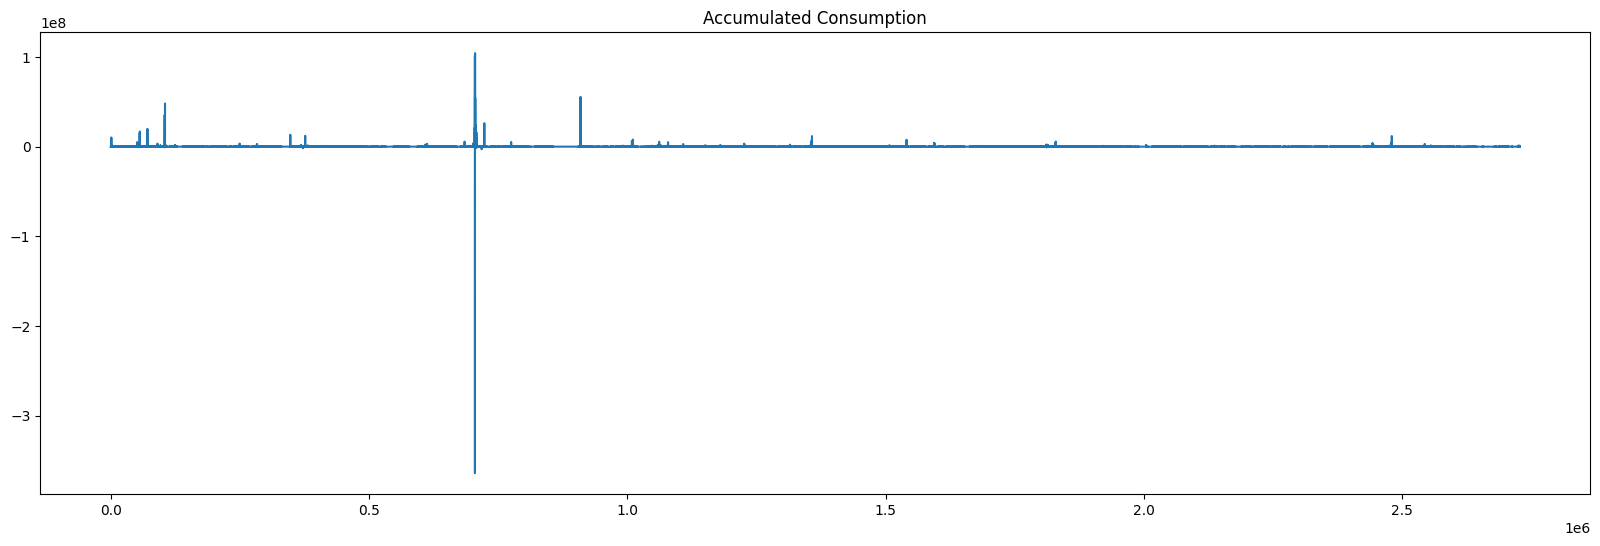

In [30]:
# plot the accumulated consumption to detect outliers
plt.figure(figsize=(20, 6))
plt.plot(merged_data['Accumulated Consumption'])
plt.title('Accumulated Consumption')
plt.show()

In [31]:
# Drop all the accumulated consumption values below 0
merged_data = merged_data[merged_data['Accumulated Consumption'] > 0]

In [32]:
merged_data.describe()

,Date,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
count,2719056,2.719056e+06,2.719056e+06,2.719056e+06,2.719056e+06,2.719056e+06,2.719056e+06,2.719056e+06
mean,2022-07-21 22:58:51.459741696,2.212636e+02,2.297878e+04,2.189202e+01,1.378303e+01,9.225469e-01,4.671801e+04,3.211541e+04
min,2021-01-01 00:00:00,2.000000e+00,1.000000e+00,6.100000e+00,1.000000e-01,0.000000e+00,1.775000e+03,4.411000e+03
25%,2021-10-30 00:00:00,2.300000e+01,3.398000e+03,1.630000e+01,8.700000e+00,0.000000e+00,3.408600e+04,2.622300e+04
50%,2022-07-28 00:00:00,6.500000e+01,7.155000e+03,2.170000e+01,1.345000e+01,0.000000e+00,5.099300e+04,3.386600e+04
75%,2023-04-18 00:00:00,4.220000e+02,1.304800e+04,2.765000e+01,1.940000e+01,1.000000e-01,6.302200e+04,3.965800e+04
max,2023-12-31 00:00:00,2.917000e+03,1.043230e+08,3.695000e+01,2.805000e+01,3.670000e+01,7.908600e+04,5.517800e+04
std,NaN,2.480662e+02,5.359958e+05,6.474325e+00,6.239103e+00,3.534839e+00,2.033710e+04,1.020411e+04


In [33]:
# There's a couple of observations with the Census Section and the District columns that are <NULL> and >. We will drop these rows
merged_data = merged_data[merged_data['Census Section'] != '<NULL>']
merged_data = merged_data[merged_data['District'] != '>']
merged_cleaned_data = merged_data

In [ ]:
# Save CSV data

# Create the directory if it does not exist
os.makedirs('../data/local_data/', exist_ok=True)

# Save the cleaned dataset
merged_cleaned_data.to_csv('../data/local_data/merged_cleaned_data_NEW.csv', index=False)

In [35]:
merged_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2715771 entries, 0 to 2724309
Data columns (total 11 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Census Section           object        
 1   District                 object        
 2   Date                     datetime64[ns]
 3   Use                      object        
 4   Number of Meters         int64         
 5   Accumulated Consumption  int64         
 6   Max Temperature          float64       
 7   Min Temperature          float64       
 8   Precipitation            float64       
 9   Tourist Accommodations   float64       
 10  Hotel Overnight Stays    int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(3)
memory usage: 238.3+ MB


In [36]:
merged_cleaned_data.describe()

,Date,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
count,2715771,2.715771e+06,2.715771e+06,2.715771e+06,2.715771e+06,2.715771e+06,2.715771e+06,2.715771e+06
mean,2022-07-21 23:33:37.213233152,2.207187e+02,2.283672e+04,2.189221e+01,1.378319e+01,9.225452e-01,4.671961e+04,3.211621e+04
min,2021-01-01 00:00:00,2.000000e+00,1.000000e+00,6.100000e+00,1.000000e-01,0.000000e+00,1.775000e+03,4.411000e+03
25%,2021-10-30 00:00:00,2.300000e+01,3.395000e+03,1.630000e+01,8.700000e+00,0.000000e+00,3.408600e+04,2.622300e+04
50%,2022-07-28 00:00:00,6.500000e+01,7.146000e+03,2.170000e+01,1.345000e+01,0.000000e+00,5.099300e+04,3.386600e+04
75%,2023-04-18 00:00:00,4.220000e+02,1.302300e+04,2.765000e+01,1.940000e+01,1.000000e-01,6.302200e+04,3.965800e+04
max,2023-12-31 00:00:00,1.452000e+03,1.043230e+08,3.695000e+01,2.805000e+01,3.670000e+01,7.908600e+04,5.517800e+04
std,NaN,2.460295e+02,5.362665e+05,6.474300e+00,6.239104e+00,3.534864e+00,2.033611e+04,1.020362e+04
